In this module, we prepare the time series model for the uncertain inflow energy $X_t$.

Whole model description:  
https://www2.isye.gatech.edu/people/faculty/Alex_Shapiro/Rep-Dec2011.pdf

In [1]:
import pandas
import numpy
# read historical data for the four reserviors
hist = [
    pandas.read_csv(
        "./data/hist_{}.csv".format(i), 
        sep=";",
        index_col=0,
    ) 
    for i in range(4)
]
# concatenate the data to fill missing value yearly
hist_all = pandas.concat(hist, axis=1, ignore_index=True)
hist_all.fillna(hist_all.mean(), inplace=True)
hist_all_log = numpy.log(hist_all)
# split the data back to individual reserviors
hist = [hist_all.iloc[:,12*i:12*(i+1)] for i in range(4)]

Let $Y_t = log(X_t)$. We hope to fit into the following model:  
\begin{equation}
    Y_t - \mu_t = \phi_t(Y_{t-1}-\mu_{t-1})+ \epsilon_t
\end{equation}
Where: 
1. $\mu_t=\mu_{t+12}$ be the monthly averages of $Y_t$  
2. $\epsilon_t$ independently follows multivariate normal distribution

The above model is not linear w.r.t $X_t$. Plug in $Y_t = log(X_t)$ and linearize the model (first order taylor expansion approximation), we get the following model  

\begin{equation}
    X_t = e^{\epsilon_t} [\tilde{\mu}_t + \gamma_t \frac{\tilde{\mu}_t}{\tilde{\mu}_{t-1}} (X_{t-1}-\tilde{\mu}_{t-1})]
\end{equation}
Where:
1. $\gamma_t = \gamma_{t+12}$  
2. $\tilde{\mu}_t = e^{\mu_t},\tilde{\mu}_{t+12}=\tilde{\mu}_t$    
2. $\epsilon_t$ independently follows multivariate normal distribution $N(0,\Sigma_t)$, $\Sigma_{t+12}=\Sigma_{t}$  

This model is called auto-regressive process with multiplicative error. We will fit into this model.  

Denote $R_t = \frac{X_t - \tilde{\mu}_t}{\tilde{\mu}_t}$ and set $\epsilon_t$ to 0, the above model can be written as  
\begin{equation}
    R_t = \gamma_t R_{t-1}
\end{equation}
$\Sigma_t$ is modelled as sample covariance matrix for  
\begin{equation}
    log(\frac{X_t}{(1-\gamma_t)\tilde{\mu}_t +\gamma_t \frac{\tilde{\mu}_t}{\tilde{\mu}_{t-1}} X_{t-1}})
\end{equation}

Compute $\tilde{\mu}_t$ 

In [42]:
hist_log = [numpy.log(hist[i]) for i in range(4)]
mu = [hist_log[i].mean().values for i in range(4)]
exp_mu = numpy.exp(mu).T

Perform least square fit to the $R_t$ sequence on a monthly basis. Beware to keep temporal order (December data should be lagged properly).

In [34]:
gamma = numpy.empty([12,4])
for i in range(4):
    for t in range(12):
        if t == 0:
            X = hist[i].iloc[:-1,11]
            Y = hist[i].iloc[1:,0]
        else:
            X = hist[i].iloc[:,t-1]
            Y = hist[i].iloc[:,t]
        X = X/exp_mu.iloc[t-1,i] - 1
        Y = Y/exp_mu.iloc[t,i] - 1
        gamma[t][i] = numpy.dot(X,Y)/numpy.dot(X,X)

Compute the sample cov

In [19]:
sigma = [None] * 12
for t in range(12):
    if t == 0:
        X = pandas.DataFrame([hist[i].iloc[:-1,11] for i in range(4)]).T
        Y = pandas.DataFrame([hist[i].iloc[1:,0] for i in range(4)]).T
    else:
        X = pandas.DataFrame([hist[i].iloc[:,t-1] for i in range(4)]).T
        Y = pandas.DataFrame([hist[i].iloc[:,t] for i in range(4)]).T
    X.reset_index(drop=True,inplace=True)
    Y.reset_index(drop=True,inplace=True)
    X.columns = [0,1,2,3]
    Y.columns = [0,1,2,3]
    matrix = numpy.log(
        Y
        / (
            (1-gamma.iloc[t]) * exp_mu.iloc[t] 
            + gamma.iloc[t] * exp_mu.iloc[t]/exp_mu.iloc[t-1] * X
        )
    )
    sigma[t] = numpy.cov(matrix.T,ddof=1)

Now we can construct a sample path generator for the above time series model

In [43]:
def generator(random_state, size):
    inflow = numpy.empty([size,13,4])
    inflow[:,0,:] = [[41248.715300,7386.860854,10124.561460,6123.808537]]
    for t in range(12):
        noise = numpy.exp(random_state.multivariate_normal(
            mean=[0]*4, cov=sigma[t],size=size))
        inflow[:,t+1,:] = noise * (
            (1-gamma[t]) * exp_mu[t]
            + gamma[t] * exp_mu[t]/exp_mu[t-1] * inflow[:,t,:]
        )
    return inflow[:,1:,:]

Use our sample path generator to simulate inflow data. 

In [44]:
import matplotlib.pyplot as plt
from msppy.utils.plot import fan_plot
simulation = [[] for _ in range(4)]
a = generator(numpy.random.RandomState(0),100)

Use fan plots to compare simulated data and historical data. The black dash line represents the average value. Plots on the left column show the simulated data while plots on the right column show the historical data. It is clear that the shapes are similar, except that the simulated data for the second reservior have a bit more tails than the real data. This behavior is also recognized in the paper:  

http://www.optimization-online.org/DB_FILE/2017/09/6201.pdf  

Overall, the above time series model fits well to the data. 

For more discussion of validating the above model, have a look at the following paper:    
https://www2.isye.gatech.edu/people/faculty/Alex_Shapiro/Rep-Dec2011.pdf

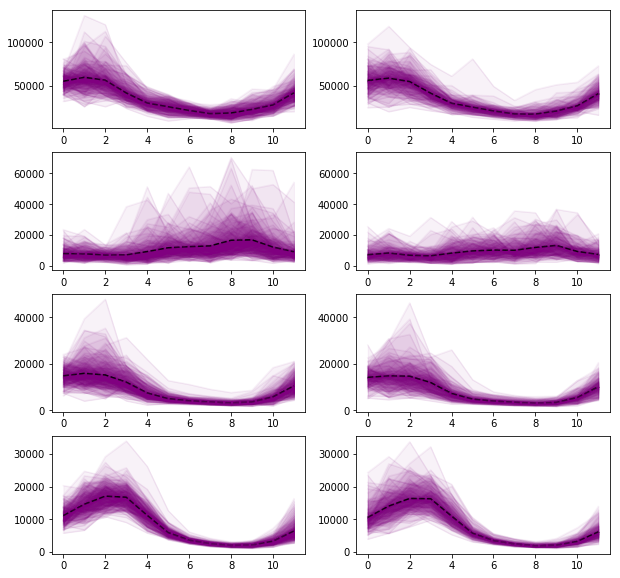

In [51]:
fig = plt.figure(figsize=(10,10))
ax = [None] * 4
ax[0] = plt.subplot(421)
ax[1] = plt.subplot(423)
ax[2] = plt.subplot(425)
ax[3] = plt.subplot(427)
for i in range(4):
    fan_plot(a[:,:,i], ax[i])
bx = [None] * 4
bx[0] = plt.subplot(422, sharey=ax[0])
bx[1] = plt.subplot(424, sharey=ax[1])
bx[2] = plt.subplot(426, sharey=ax[2])
bx[3] = plt.subplot(428, sharey=ax[3])
for i in range(4):
    fan_plot(hist[i].values, bx[i])

Output coefficients of the generator for later use.

In [8]:
pandas.DataFrame(gamma).to_csv("./data/gamma.csv")
for t in range(12):
    pandas.DataFrame(sigma[t]).to_csv("./data/sigma_{}.csv".format(t))
pandas.DataFrame(exp_mu).to_csv("./data/exp_mu.csv")